xsj110 - Jacob Molin Nielsen

# Introduction
In this notebook two ML models are presented. The first model is a graph convolutional model. The second model uses MACCS fingerprints to represent the molecules.

The dataset is part of an active ITS project.

About the project
---
One major challenge regarding cancer chemotherapy is the phenomenon known as multidrug resistance (MDR) in which the cancer cells acquire resistance to various drugs. A well-known mechanism causing MDR is the overexpression of MDR-related transporters responsible for the translocation of the chemotherapeutic agents [1]. This translocation results in low intracellular concentration and increased metabolism of chemotherapeutic drugs. The transporters mainly responsible for the translocation of chemotherapeutic drugs belong to the so-called ATP binding cassette (ABC) transporters, of which the ABCG2 (BCRP), ABCB1 (MDR1), ABCC1-6 (MRP1-6), and ABCC10-12 (MRP7-9) are the most important MDR-related transporters. 


One way to overcome MDR is by the application of MDR inhibitors used to block the 
MDR- related transporters. Ko143 and zosuquidar are two well-known and efficient MDR inhibitors targeting the BCRP and MDR1 respectively. A way to obtain an easy and fast prediction of new MDR inhibitors is by using a virtual screening platform. One such way has recently been implemented [2]. 

In this project a machine learning model will be developed to give predictive power for new novel ligands that targets ABC-transporters.

[1]	R. W. Robey, K. M. Pluchino, M. D. Hall, A. T. Fojo, S. E. Bates, and M. M. Gottesman, “Revisiting the role of ABC transporters in multidrug-resistant cancer,” Nature Reviews Can- cer, vol. 18, no. 7, pp. 452–464, Jul. 2018. 

[2]	Simone Klemensen Drejer: In silico modelling of drug resistance related proteins and model validation in cellular assays, Specialerapport, 2022

In [1]:
# !pip install deepchem -qqq
# !pip install dgl==0.9 -qqq
# !pip install dgllife -qqq
# !pip install pyGPGO -qqq

In [2]:
# Due to the large file sizes of the *.sdf files, I created this csv file instead.
# This only contains docking scores and SMILE strings for each molecule.
# %%bash
# wget https://raw.githubusercontent.com/MolinDiscovery/MDRinhib-test/master/ABC_smiles_data.csv

In [3]:
import pandas as pd
import numpy as np
import rdkit as rd
import tensorflow as tf
import matplotlib.pyplot as plt

from deepchem import deepchem as dc # Needs to me imported weirdly in VS code
from deepchem.models import GraphConvModel

from rdkit import Chem
from rdkit.Chem import Draw

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_sparse'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\xsj110\AppData\Local\Programs\Python\Python38\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jaxlib'


# Dataset and preprocessing

The dataset consist of 12 columns. The first 11 columns contains docking scores (computed dG) for 11 different ABC-transporters. The last row contain a SMILES representation for each molecule. This is a little bit different from the dataset initially proposed namely that the molecular representations came from an .sdf. This file was so large that it became a problem and so I resolved to this solution.

How was the data generated?
---
The scores are a product of a previous master student from PharmaSchool who docked every FDA-approved molecule using glide docking in the Mestro software package by Schrödinger.

In [4]:
df = pd.read_csv('ABC_smiles_data.csv')
df = df.set_index('1')
df

,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,MRP9,SMILES
1,,,,,,,,,,,,
8-HOUR BAYER; ASPIRIN,-5.3,-6.4,-5.1,-4.9,-4.1,-5.1,-9.3,-4.1,-3.5,-4.2,-6.6,CC(=O)Oc1ccccc1C(=O)[O-]
8-MOP; METHOXSALEN,-8.0,-6.4,-4.8,-3.9,-4.7,-4.7,-3.8,-3.9,-4.7,-5.7,-3.4,COc1c2occc2cc2ccc(=O)oc12
A-POXIDE; CHLORDIAZEPOXIDE HYDROCHLORIDE,-10.1,-10.7,-7.9,-6.9,-7.9,-6.9,-8.5,-6.2,-4.4,-9.7,-9.5,CNC1=Nc2ccc(Cl)cc2C(c2ccccc2)=[N+]([O-])C1
ABACAVIR AND LAMIVUDINE; LAMIVUDINE,-7.1,-6.3,-5.9,-6.7,-5.0,-5.0,-7.4,-5.6,-5.2,-4.6,-6.7,Nc1ccn([C@H]2CS[C@H](CO)O2)c(=O)n1
"ABACAVIR SULFATE, LAMIVUDINE AND ZIDOVUDINE; ZIDOVUDINE",-6.8,-7.6,-5.5,-4.6,-5.3,-5.1,-6.6,-4.4,-5.0,-3.8,-5.0,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...
...,...,...,...,...,...,...,...,...,...,...,...,...
ZONTIVITY; VORAPAXAR SULFATE,-10.1,-8.6,-5.2,-5.8,-5.9,-6.9,-7.5,-3.2,-3.9,-5.8,-5.9,CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O...
ZYDELIG; IDELALISIB,-9.3,-8.5,-6.4,-5.2,-6.1,-8.2,-7.2,-6.0,-5.4,-6.3,-6.0,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...
ZYFLO CR; ZILEUTON,-7.4,-7.6,-5.7,-7.1,-6.6,-5.9,-6.3,-5.5,-5.3,-5.6,-6.7,C[C@@H](c1cc2ccccc2s1)N(O)C(N)=O


In [5]:
# create rdkit objects from smiles unless the column alreadt exist.
if 'molecules' not in df.columns:
    df['molecules'] = df['SMILES'].apply(Chem.MolFromSmiles)

# store name of receptors in a list
receptors = df.iloc[:, :11].columns.tolist()
df

,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,MRP9,SMILES,molecules
1,,,,,,,,,,,,,
8-HOUR BAYER; ASPIRIN,-5.3,-6.4,-5.1,-4.9,-4.1,-5.1,-9.3,-4.1,-3.5,-4.2,-6.6,CC(=O)Oc1ccccc1C(=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x000001B74CE...
8-MOP; METHOXSALEN,-8.0,-6.4,-4.8,-3.9,-4.7,-4.7,-3.8,-3.9,-4.7,-5.7,-3.4,COc1c2occc2cc2ccc(=O)oc12,<rdkit.Chem.rdchem.Mol object at 0x000001B74CE...
A-POXIDE; CHLORDIAZEPOXIDE HYDROCHLORIDE,-10.1,-10.7,-7.9,-6.9,-7.9,-6.9,-8.5,-6.2,-4.4,-9.7,-9.5,CNC1=Nc2ccc(Cl)cc2C(c2ccccc2)=[N+]([O-])C1,<rdkit.Chem.rdchem.Mol object at 0x000001B74CE...
ABACAVIR AND LAMIVUDINE; LAMIVUDINE,-7.1,-6.3,-5.9,-6.7,-5.0,-5.0,-7.4,-5.6,-5.2,-4.6,-6.7,Nc1ccn([C@H]2CS[C@H](CO)O2)c(=O)n1,<rdkit.Chem.rdchem.Mol object at 0x000001B74CE...
"ABACAVIR SULFATE, LAMIVUDINE AND ZIDOVUDINE; ZIDOVUDINE",-6.8,-7.6,-5.5,-4.6,-5.3,-5.1,-6.6,-4.4,-5.0,-3.8,-5.0,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,<rdkit.Chem.rdchem.Mol object at 0x000001B74CE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZONTIVITY; VORAPAXAR SULFATE,-10.1,-8.6,-5.2,-5.8,-5.9,-6.9,-7.5,-3.2,-3.9,-5.8,-5.9,CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O...,<rdkit.Chem.rdchem.Mol object at 0x000001B74C8...
ZYDELIG; IDELALISIB,-9.3,-8.5,-6.4,-5.2,-6.1,-8.2,-7.2,-6.0,-5.4,-6.3,-6.0,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,<rdkit.Chem.rdchem.Mol object at 0x000001B74C8...
ZYFLO CR; ZILEUTON,-7.4,-7.6,-5.7,-7.1,-6.6,-5.9,-6.3,-5.5,-5.3,-5.6,-6.7,C[C@@H](c1cc2ccccc2s1)N(O)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x000001B74C8...


# Helper functions

In [6]:
def data_for_receptor(df, receptor_name, seed=1):
    '''
    This function takes the dataframe created for all receptors and returns
    training, validation and test data that can be used in a GraphConvModel.
    '''
    
    # This code takes the initial df and republish it with data only on one receptor
    df_receptor =  df[[receptor_name, 'molecules']]
    # Applying a mask to remove possible 0 values.
    mask = df_receptor['molecules'] == 0
    df_receptor = df_receptor.drop(df[mask].index)

    feat = dc.feat.ConvMolFeaturizer()
    X = feat.featurize(df_receptor['molecules'])
    y = df_receptor[receptor_name].to_numpy()
    ids = df_receptor.index

    # Create dataset for deepchem
    dataset = dc.data.NumpyDataset(X=X, y=y, ids=ids)

    # Transform the output data for regression
    transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)
    dataset = transformer.transform(dataset)

    # split data
    splitter = dc.splits.RandomSplitter()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1,
    seed=seed,
    )

    return train_dataset, valid_dataset, test_dataset, transformer

# Graph Convolutional Models

### Preliminary explation
Two GC models are created. The first one is only using the docking scores from one receptor in the model. This means only one task is performed.

X = [mol1, mol2, mol3, ...]

y_BCRP = [-5.3, 4.2, 9.3, ...]

The second model has every docking score as y-value; a multitask model.

X = [mol1, mol2, mol3, ...]

y = [[-5.3, 4.2, 9.3, ...], [-5.3, 4.2, 9.3, ...] [...]x11]

The idea is to compare and see if one model is better or worse.

## Theory
The idea of graph convolution is to represent a molecule as a list of numbers where the atoms are the nodes and the bonds are edges, or the lines connecting the atoms. Each atom is represented by a feature vector, which encodes different information about each atom. This can be seen in the example below, where the features are atom type, hybridisation, chemical properties (here VWD radius) and last if it's in a ring system or not. This is done for every atom as part of the featurization process.

Additionally, to capture the surrounding environment of the node the feature vectors for each bonded atom is combined and multiplied by another weight. These are passed through an actication function to yield an atomic embedding vector, which is represented as a blue vector below. Finally, each embedding vector are added and averaged for a final representation of the molecule, which can be handed to a neural network.

The GraphConvModel uses a neural network that updates using the ReLU function. This might be a problem since all values are negative in the dataset, but the model does perform alright, and this might be because the data is transformed using the normalization transformer.

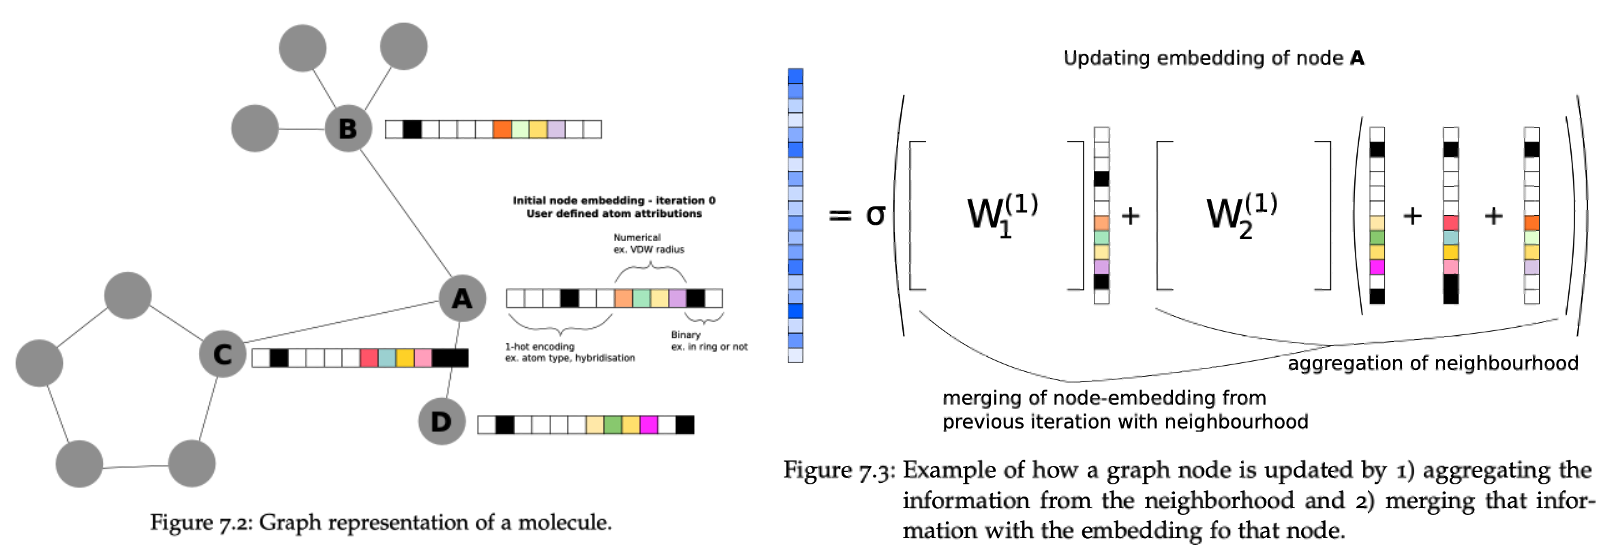
Source: Rasmussen, M. H. (2022). EXPLORING CHEMICAL REACTION SPACE: fast, automated, accurate....... choose
two.

## Hyperparameter Optimization (this process will take 1-3 hours - skipped by default)

The hyperparamterer optimization is done for the first receptor, BCRP, and this optimization works as a proxy for the other models. The reason being the extremely time-consuming nature of this process. First a grid search is used to search a wide space of parameters which is followed by a gaussian optimization process.

In [7]:
# do_hyper_opt is False to avoid this long process.
do_hyper_opt = False
opt_hyp_params = False

In [8]:
if do_hyper_opt == True:

    optimizer = dc.hyper.GridHyperparamOpt(dc.models.GraphConvModel)
    metric = dc.metrics.Metric(dc.metrics.rms_score)

    params_dict = {
        'n_tasks': [1],
        'graph_conv_layers':  [[32, 32], [64, 64], [64, 64, 64, 64]],
        'number_atom_features': [10, 50, 100],
        'learning_rate': [0.1, 0.001, 0.0001],
        'dropout': [0.1, 0.01, 0.001],
        'mode': ['regression'],
    }

    train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'BCRP', seed=1)

    best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
        params_dict=params_dict,
        train_dataset=train_dataset,
        valid_dataset=valid_dataset,
        metric=metric,
        output_transformers=[transformer],
        use_max=False,
        nb_epoch=10,
    )
    opt_hyp_params = True
    best_layers_size = best_hyperparams.get('graph_conv_layers')

    # Gaussian process hyperoptimization
    def model_builder(**model_params):
        return GraphConvModel(n_tasks=1, mode='regression', batch_size=32, graph_conv_layers=best_layers_size)

    optimizer = dc.hyper.GaussianProcessHyperparamOpt(model_builder=model_builder, max_iter=20)

    params_dict = {
        "number_atom_features": best_hyperparams.get('number_atom_features'),
        "learning_rate": best_hyperparams.get('learning_rate'),
        "dropout": best_hyperparams.get('dropout'),
    }

    best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
        params_dict=params_dict,
        train_dataset=train_dataset,
        valid_dataset=valid_dataset,
        output_transformers=[transformer],
        metric=metric,
        use_max=False,
        nb_epoch=10,
        logfile='results_gaus.txt'
    )

## Set hyperparameters
Here a set of hyperparameters are set. If hyperparameter optimization has been completed it will use these instead. The hyperparameters used otherwise are from a previous attempt of running the hyperparameter optimization tool implemented above.

In [9]:
# Global metric
metrics = [
    dc.metrics.Metric(dc.metrics.rms_score),
    dc.metrics.Metric(dc.metrics.mean_absolute_error),
]

# Global hyperparameters
batch_size = 32

if opt_hyp_params == True:
    n_feat = best_hyperparams.get('number_atom_features')
    learning_rate = best_hyperparams.get('learning_rate')
    dropout = best_hyperparams.get('dropout')
    graph_conv_layers = best_layers_size
else:
    # These parameters were found during an earlier iteration of hyperparameter optimization
    n_feat = 27
    learning_rate = 0.0004
    dropout = 0.004
    graph_conv_layers = [64, 64]

tasks = 1
epochs = 50
callback_interval = 300 # epochs*5

## Single task model
Instead of feeding the model all the data, the model is handed docking scores for one receptor only. Preparing the data is handled by data_for_receptor().

A model is trained for each receptor and stored in the models list. For this assignment only the first model is computed, which is BCRP.
This is archieved by only running the loop once: receptors[0:1].

In [10]:
models = []

for curr_recept in receptors[0:1]:
    print('Computing model for', curr_recept)
    train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, curr_recept, seed=1)
    callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=callback_interval, metrics=metrics, transformers=[transformer])

    model = GraphConvModel(
        n_tasks=tasks,
        batch_size=batch_size,
        mode='regression',
        number_atom_features=n_feat,
        learning_rate=learning_rate,
        graph_conv_layers=graph_conv_layers,
        dropout=dropout,
    )

    model.fit(train_dataset, nb_epoch=epochs, callbacks=callback)
    models.append([model, train_dataset, valid_dataset, test_dataset, transformer, curr_recept])
    print('')

Computing model for BCRP
Step 300 validation: rms_score=1.95033 mean_absolute_error=1.41059
Step 600 validation: rms_score=1.73962 mean_absolute_error=1.32176
Step 900 validation: rms_score=1.66967 mean_absolute_error=1.27845
Step 1200 validation: rms_score=1.7255 mean_absolute_error=1.28827



### Validation

In [11]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))
train_plot_dataset = transformer.untransform(train_dataset.y)
test_plot_dataset = transformer.untransform(test_dataset.y)

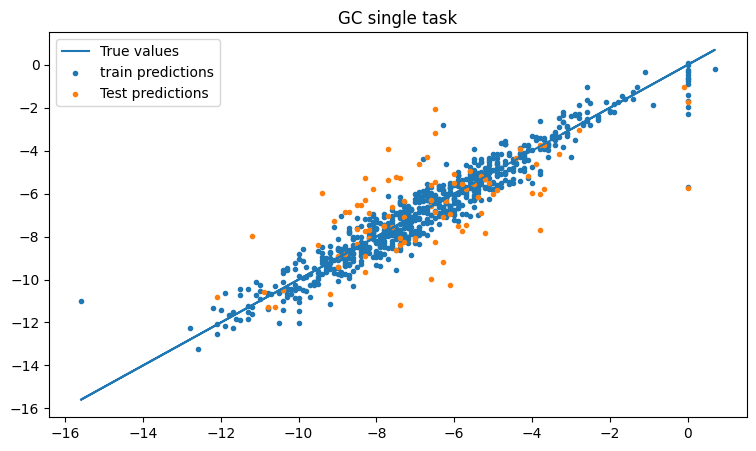

In [12]:
plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset, train_plot_dataset, label='True values')
plt.scatter(train_plot_dataset, train_preds, marker='.', label='train predictions')
plt.scatter(test_plot_dataset, test_preds, marker='.', label='Test predictions')
plt.legend()
plt.title('GC single task')
plt.savefig('GCS.png')

In [13]:
test_mean = np.mean(test_preds)
test_std  = np.std(test_preds)

metric = dc.metrics.Metric(dc.metrics.rms_score)
RMSE   = model.evaluate(test_dataset, metric, transformers=[transformer]).get('rms_score')

print('Test set')
print('  Average: ', test_mean)
print('Std. dev.: ', test_std)
print('    RMSE : ', RMSE)

Test set
  Average:  -6.752492
Std. dev.:  2.1151462
    RMSE :  1.7821573148422902


#### Dataset sensitivity
The model was run with seed=1 and 5 which yielded these results


Test set Seed=1
Average sol.:  -6.734172
   Std. dev.:  1.9986268
       RMSE :  1.6412736780107118

Test set Seed=5
Average sol.:  -6.434563
   Std. dev.:  1.8549199
       RMSE :  1.6972726716364435

So this model is not particurly sensitive to alterations of the dataset.

#### Range analysis

In [14]:
sorted_data = df[['BCRP', 'molecules']].sort_values(by=['BCRP'])
feat = dc.feat.ConvMolFeaturizer()
X = feat.featurize(sorted_data['molecules'])
y = sorted_data['BCRP']
sorted_dataset = dc.data.NumpyDataset(X=X, y=y)
sorted_data

splitter = dc.splits.IndexSplitter()
high, med, low = splitter.train_valid_test_split(
    dataset = sorted_dataset,
    frac_train = (1/3),
    frac_valid = (1/3),
    frac_test = (1/3),
)
high = transformer.transform(high)
med = transformer.transform(med)
low = transformer.transform(low)

In [15]:
high_preds = model.predict(high, [transformer])
med_preds = model.predict(med, [transformer])
low_preds = model.predict(low, [transformer])

metric = dc.metrics.Metric(dc.metrics.rms_score)
print("From low to high scores")
print("RMSE", model.evaluate(high, metric, [transformer]).get('rms_score'))
print("RMSE", model.evaluate(med, metric, [transformer]).get('rms_score'))
print("RMSE", model.evaluate(low, metric, [transformer]).get('rms_score'), end="\n\n")

print("SD", np.std(high_preds), "Avg", np.mean(high_preds))
print("SD", np.std(med_preds), "Avg", np.mean(med_preds))
print("SD", np.std(low_preds), "Avg", np.mean(low_preds))

From low to high scores
RMSE 1.0246572416279756
RMSE 0.9848977237486121
RMSE 1.0103602414116075

SD 1.4497883 Avg -9.04598
SD 1.1184868 Avg -6.86265
SD 1.656879 Avg -4.399547


The model is slightly better in the middle of the dataset.

## Multitask model

For the multitask all docking scores are handed to the model at once.

In [16]:
# Featurize and ready data
feat = dc.feat.ConvMolFeaturizer()
X = feat.featurize(df['molecules'])
y = df.loc[:,receptors[:11]].to_numpy()
ids = df.index

dataset = dc.data.NumpyDataset(X=X, y=y, ids=ids)

# Transform the output data for regression
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)
dataset = transformer.transform(dataset)

In [17]:
# Split the data
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1,
    seed=5,
)

In [18]:
# Build the model
tasks = len(dataset.y[0])
model = GraphConvModel(
    n_tasks=tasks,
    batch_size=batch_size,
    mode='regression',
    number_atom_features=n_feat,
    learning_rate=learning_rate,
    dropout=dropout,
    graph_conv_layers=graph_conv_layers,
)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=callback_interval, metrics=metrics, transformers=[transformer])
model.fit(train_dataset, nb_epoch=epochs, callbacks=callback)

Step 300 validation: rms_score=1.72281 mean_absolute_error=1.34651
Step 600 validation: rms_score=1.59594 mean_absolute_error=1.2155
Step 900 validation: rms_score=1.58606 mean_absolute_error=1.19382
Step 1200 validation: rms_score=1.55058 mean_absolute_error=1.16794


0.39464359283447265

### Validation

To get the predictions and true values for BCRP the first item from every list in the sublists is fetched. This is because when the predictions are calculated a prediction for each receptor is computed.

The same must be done for the true values, when the variables `train_plot_dataset_BCRP` and `test_plot_dataset_BCRP` are set.

In [19]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))

receptor_no = 0 # 0 = BCRP (change the value to 1 to get data for MDR1 etc.)
train_preds_BCRP = [sublist[receptor_no] for sublist in train_preds]
test_preds_BCRP = [sublist[receptor_no] for sublist in test_preds]
train_plot_dataset_BCRP = [sublist[receptor_no] for sublist in transformer.untransform(train_dataset.y)]
test_plot_dataset_BCRP = [sublist[receptor_no] for sublist in transformer.untransform(test_dataset.y)]

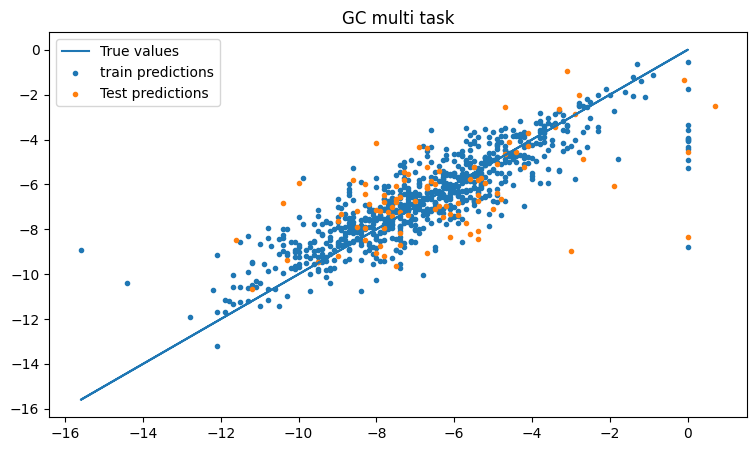

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset_BCRP, train_plot_dataset_BCRP, label='True values')
plt.scatter(train_plot_dataset_BCRP, train_preds_BCRP, marker='.', label='train predictions')
plt.scatter(test_plot_dataset_BCRP, test_preds_BCRP, marker='.', label='Test predictions')
plt.title('GC multi task')
plt.legend()
plt.savefig('GCM.png')

In [21]:
test_mean = np.mean(test_preds_BCRP)
test_std  = np.std(test_preds_BCRP)

metric = dc.metrics.Metric(dc.metrics.rms_score)
RMSE   = model.evaluate(test_dataset, metric, transformers=[transformer]).get('rms_score')

print('Test set')
print('  Average: ', test_mean)
print('Std. dev.: ', test_std)
print('    RMSE : ', RMSE)

Test set
  Average:  -6.431811509385836
Std. dev.:  1.903730586365526
    RMSE :  1.7022396736721312


#### Dataset sensitity

Test set Seed=1
Average sol.:  -6.99
   Std. dev.:  1.89
       RMSE :  1.52

Test set Seed=5
Average sol.:  -6.07
   Std. dev.:  2.11
       RMSE :  1.64

#### Range analysis

In [22]:
sorted_data = df.sort_values(by=['BCRP'])
feat = dc.feat.ConvMolFeaturizer()
X = feat.featurize(sorted_data['molecules'])
y = sorted_data.loc[:,receptors[:11]]
sorted_dataset = dc.data.NumpyDataset(X=X, y=y)
sorted_data

splitter = dc.splits.IndexSplitter()
high, med, low = splitter.train_valid_test_split(
    dataset = sorted_dataset,
    frac_train = (1/3),
    frac_valid = (1/3),
    frac_test = (1/3),
)
high = transformer.transform(high)
med = transformer.transform(med)
low = transformer.transform(low)

In [23]:
high_preds = model.predict(high, [transformer])
med_preds = model.predict(med, [transformer])
low_preds = model.predict(low, [transformer])

metric = dc.metrics.Metric(dc.metrics.rms_score)
print("From low to high docking scores")
print("RMSE", model.evaluate(high, metric, [transformer]).get('rms_score'))
print("RMSE", model.evaluate(med, metric, [transformer]).get('rms_score'))
print("RMSE", model.evaluate(low, metric, [transformer]).get('rms_score'), end="\n\n")

print("SD", np.std(high_preds), "Avg", np.mean(high_preds))
print("SD", np.std(med_preds), "Avg", np.mean(med_preds))
print("SD", np.std(low_preds), "Avg", np.mean(low_preds))

From low to high docking scores
RMSE 1.1957411368972972
RMSE 1.138742506920973
RMSE 1.3602668398113624

SD 1.7051941999664992 Avg -6.82545640202576
SD 1.4575084693394067 Avg -5.857789301104882
SD 1.5062646917043865 Avg -4.754025607107317


# MACCS fingerprint model

## Theory

What are MACCS fingerprints?

MACCS fingerprint consists of 166 bits, where each bit corresponds to a specific structural feature, such as presence of particular atom types, functional groups, or molecular scaffolds. If a specific feature is present in a molecule, the corresponding bit in the fingerprint is set to 1; otherwise, it's set to 0. This means there will be 166 input layers for the neural network.

Below is an example representation of a neural network.

Each input is passed through a set of hidden layers. Each layer contains a stack of nodes that is essentially activation functions. In this model they are calculated using a standard sigmoid function.

$
f(x) = \frac{1}{1 + e^{-X_{hidden}}}
$

This will output a value between 0 and 1.

The $X_{hidden}$ is a linear function 

$X_{hidden}=w_0+w_1X_1+w_2X2...w_nX_n$

Backpropagation is used to update the weights which is the lines between the nodes. This is done by an iterative gradient descent process. The derivative of the L2 function is used to calculate a new weight between the nodes. This is handled by DeepChem(PyTorch backend).

Finally the weights are combined into a single output without using an activation function; leaving a final prediction

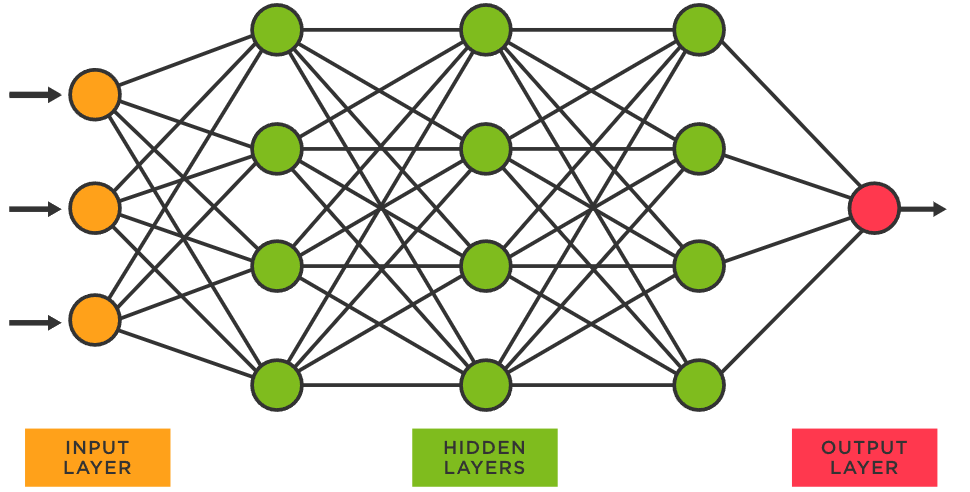

In [24]:
import torch
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from rdkit.Chem import MACCSkeys
from deepchem.models import MultitaskRegressor

In [25]:
# Generate fingerprints
fingerprints = []
for mol in df['molecules']:
    fingerprint = MACCSkeys.GenMACCSKeys(mol)
    fingerprints.append(np.array(fingerprint).astype(np.float32))

In [26]:
X = fingerprints
y = df.loc[:,receptors[:11]].to_numpy()
ids = df.index

dataset = dc.data.NumpyDataset(X=X, y=y, ids=ids)

In [27]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1,
    seed=5,
)

In [28]:
n_feat = dataset.X.shape[1]
tasks = len(dataset.y[0])
model = dc.models.MultitaskRegressor(n_tasks=tasks, n_features=n_feat, layer_sizes=[128], dropouts=0.5, learning_rate=0.001)

In [29]:
model = dc.models.MultitaskRegressor(
    n_tasks=tasks,
    n_features=n_feat,
    layer_sizes=[128, 64],
    dropouts=0.005,
    learning_rate=0.001,
    activation_fns=[torch.sigmoid, torch.sigmoid]
)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=100, metrics=metrics)
model.fit(train_dataset, nb_epoch=400, callbacks=callback)

Step 100 validation: rms_score=1.97494 mean_absolute_error=1.56183
Step 200 validation: rms_score=1.73267 mean_absolute_error=1.31932
Step 300 validation: rms_score=1.73155 mean_absolute_error=1.31843
Step 400 validation: rms_score=1.73094 mean_absolute_error=1.31787
Step 500 validation: rms_score=1.72369 mean_absolute_error=1.31178
Step 600 validation: rms_score=1.65198 mean_absolute_error=1.25042
Step 700 validation: rms_score=1.61712 mean_absolute_error=1.21121
Step 800 validation: rms_score=1.57459 mean_absolute_error=1.16327
Step 900 validation: rms_score=1.52665 mean_absolute_error=1.13408
Step 1000 validation: rms_score=1.51501 mean_absolute_error=1.12523
Step 1100 validation: rms_score=1.50932 mean_absolute_error=1.1177
Step 1200 validation: rms_score=1.50617 mean_absolute_error=1.11638
Step 1300 validation: rms_score=1.501 mean_absolute_error=1.115
Step 1400 validation: rms_score=1.51601 mean_absolute_error=1.1208
Step 1500 validation: rms_score=1.4945 mean_absolute_error=1.10

1.5425674438476562

### Validation

In [30]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

# To get the predictions and true values for BCRP we must get the first item from each list
receptor_no = 0 # 0 = BCRP (change the value to 1 to get data for MDR1 etc.)
train_preds_BCRP = [sublist[receptor_no] for sublist in train_preds]
test_preds_BCRP = [sublist[receptor_no] for sublist in test_preds]
train_plot_dataset_BCRP = [sublist[receptor_no] for sublist in train_dataset.y]
test_plot_dataset_BCRP = [sublist[receptor_no] for sublist in test_dataset.y]

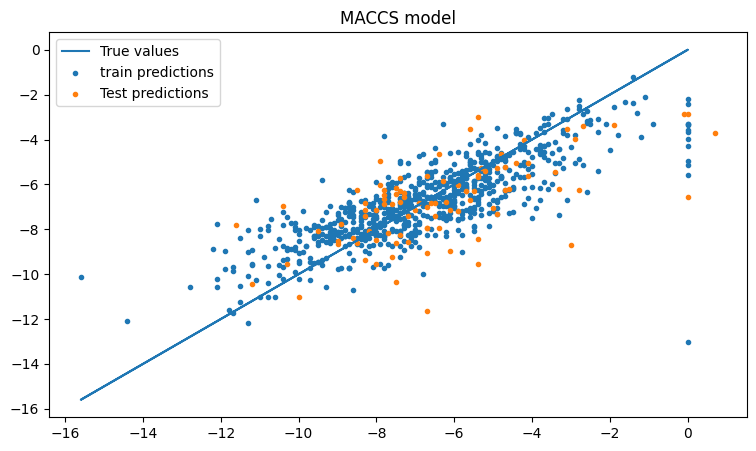

In [31]:
plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset_BCRP, train_plot_dataset_BCRP, label='True values')
plt.scatter(train_plot_dataset_BCRP, train_preds_BCRP, marker='.', label='train predictions')
plt.scatter(test_plot_dataset_BCRP, test_preds_BCRP, marker='.', label='Test predictions')
plt.legend()
plt.title('MACCS model')
plt.savefig('MACCS.png')

In [32]:
test_mean = np.mean(test_preds_BCRP)
test_std  = np.std(test_preds_BCRP)

metric = dc.metrics.Metric(dc.metrics.rms_score)
RMSE   = model.evaluate(test_dataset, metric).get('rms_score')

print('Test set')
print('Average  : ', test_mean)
print('Std. dev.: ', test_std)
print('    RMSE : ', RMSE)

Test set
Average  :  -6.7891965
Std. dev.:  1.8274635
    RMSE :  1.576250022165585


#### Dataset sensitivity

Test set Seed=1
Average sol.:  -6.658298
   Std. dev.:  1.7321352
       RMSE :  1.5200924561280276

Test set Seed=2
Average sol.:  -6.739128
   Std. dev.:  1.812408
       RMSE :  1.5507339643017561

#### Range analysis

In [33]:
sorted_data = df.sort_values(by=['BCRP'])

# Generate fingerprints
fingerprints = []
for mol in sorted_data['molecules']:
    fingerprint = MACCSkeys.GenMACCSKeys(mol)
    fingerprints.append(np.array(fingerprint).astype(np.float32))

X = fingerprints
y = sorted_data.loc[:,receptors[:11]]
sorted_dataset = dc.data.NumpyDataset(X=X, y=y)
sorted_data

splitter = dc.splits.IndexSplitter()
high, med, low = splitter.train_valid_test_split(
    dataset = sorted_dataset,
    frac_train = (1/3),
    frac_valid = (1/3),
    frac_test = (1/3),
)

In [34]:
high_preds = model.predict(high)
med_preds = model.predict(med)
low_preds = model.predict(low)

metric = dc.metrics.Metric(dc.metrics.rms_score)
print("From high to low docking scores")
print("RMSE", model.evaluate(high, metric).get('rms_score'))
print("RMSE", model.evaluate(med, metric).get('rms_score'))
print("RMSE", model.evaluate(low, metric).get('rms_score'), end="\n\n")

print("SD", np.std(high_preds), "Avg", np.mean(high_preds))
print("SD", np.std(med_preds), "Avg", np.mean(med_preds))
print("SD", np.std(low_preds), "Avg", np.mean(low_preds))

From high to low docking scores
RMSE 1.2574211067363676
RMSE 1.1956587355400627
RMSE 1.483700840102163

SD 1.5607698 Avg -6.9645343
SD 1.243249 Avg -5.923847
SD 1.2747709 Avg -4.730183


# Issues with points around 0

In [79]:
#[num for num in train_plot_dataset_BCRP if num > -1]

BCRP_test_true = [sublist[0] for sublist in test_dataset.y]
zero_binders = [(index, num) for index, num in enumerate(BCRP_test_true) if num > -1]
print(zero_binders)



[(6, 0.0), (27, -0.1), (43, 0.0), (51, 0.7)]


6

In [87]:
zero_binders_indices = [6, 27, 43, 51]
zero_binders_compounds = [test_dataset.ids[i] for i in zero_binders_indices if i < len(test_dataset.ids)]
zero_binders_df = df.loc[zero_binders_compounds]
zero_binders_df



,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,MRP9,SMILES,molecules
1,,,,,,,,,,,,,
COSMEGEN; DACTINOMYCIN,0.0,0.0,0.0,-3.8,0.0,0.0,0.0,0.0,-1.9,-1.6,0.0,Cc1c2oc3c(C)ccc(C(=O)N[C@@H]4C(=O)N[C@H](C(C)C...,<rdkit.Chem.rdchem.Mol object at 0x000001B74C8...
CYSTADANE; BETAINE HYDROCHLORIDE,-0.1,-2.7,-2.6,-3.4,-4.5,0.0,-2.6,-4.6,-2.3,-2.4,-4.5,C[N+](C)(C)CC(=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x000001B74C8...
AMANTADINE HYDROCHLORIDE; AMANTADINE HYDROCHLORIDE,0.0,-2.0,-3.6,0.0,-1.7,0.0,-1.3,-1.2,-3.4,-3.1,-1.5,[NH3+][C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x000001B74C8...
MEMANTINE; MEMANTINE,0.7,-6.2,-4.3,0.0,-4.0,-3.8,-4.2,-3.6,-4.4,-3.1,-2.9,C[C@]12C[C@@H]3C[C@](C)(C1)C[C@@]([NH3+])(C3)C2,<rdkit.Chem.rdchem.Mol object at 0x000001B74C8...


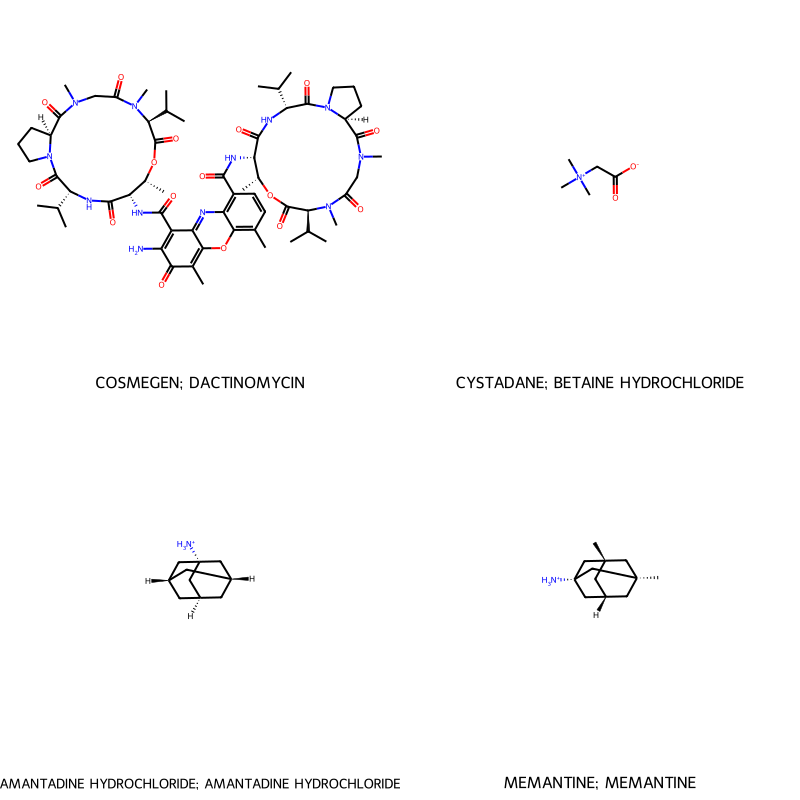

In [93]:
img = Draw.MolsToGridImage(
    zero_binders_df['molecules'],
    molsPerRow=2,
    subImgSize=(400, 400),
    legends=[x for x in zero_binders_compounds]
)
img

# Results summary

GC test set (single task)
```
Evaluation (test set seed=1)
Average sol.:  -6.93
   Std. dev.:  1.90
       RMSE :  1.63

Dataset sensitivity (test set seed=5)
Average sol.:  -6.43
   Std. dev.:  1.85
       RMSE :  1.69

Range analysis (from low to high values)
High: RMSE 0.91 | SD 1.41 | Avg -9.26
Med : RMSE 0.85 | SD 0.99 | Avg -7.00
Low : RMSE 1.04 | SD 1.60 | Avg -4.60

```
GC test set (multi task)

```
Evaluation (test set seed=1)
Average sol.:  -6.54
   Std. dev.:  1.61
       RMSE :  1.66

Dataset sensitivity (test set seed=5)
Average sol.:  -6.07
   Std. dev.:  2.11
       RMSE :  1.64

From high to low docking scores
RMSE 1.20 | SD 1.65 | Avg -6.82
RMSE 1.12 | SD 1.39 | Avg -5.86
RMSE 1.33 | SD 1.50 | Avg -4.75

```
MACCS fingerprint model
```
Evaluation (test set seed=1)
Average sol.:  -6.66
   Std. dev.:  1.73
       RMSE :  1.52

Dataset sensitivy (Test set Seed=5)
Average sol.:  -6.74
   Std. dev.:  1.81
       RMSE :  1.55

From good to bad docking scores
RMSE 1.25 | SD 1.56 | Avg -6.93
RMSE 1.19 | SD 1.24 | Avg -5.90
RMSE 1.48 | SD 1.26 | Avg -4.70

```









,,

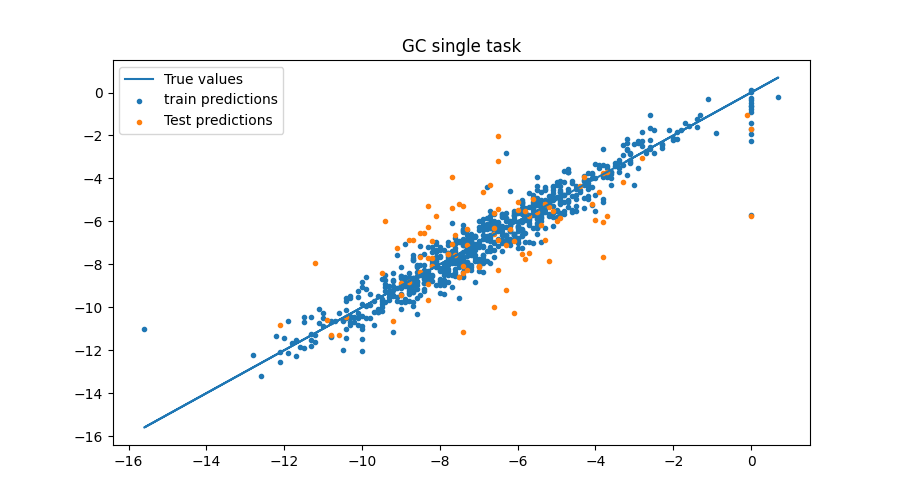
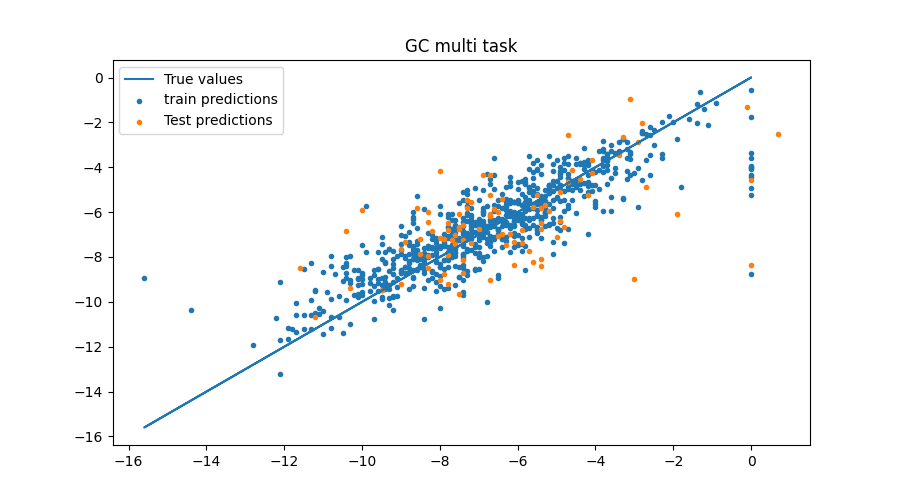
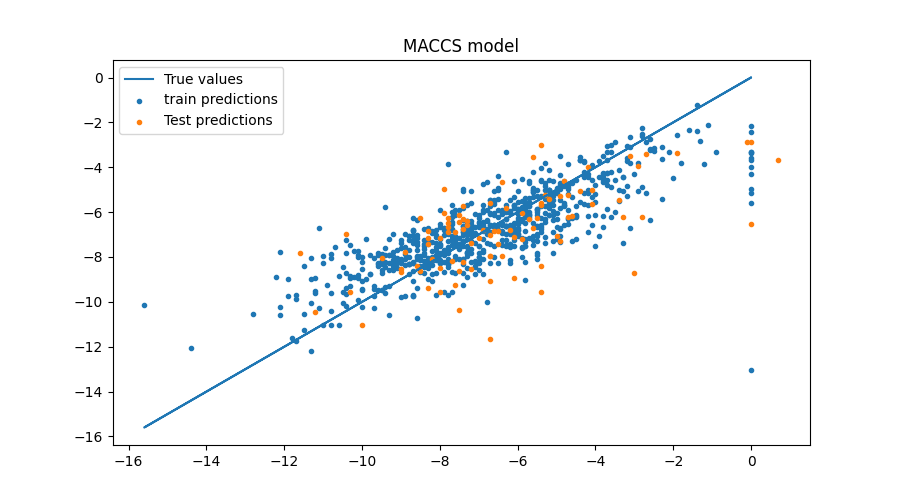

In [35]:
from IPython.display import display, HTML
from IPython.display import Image as IPImage
image1 = IPImage(filename='GCS.png'); image2 = IPImage(filename='GCM.png'); image3 = IPImage(filename='MACCS.png')
display(HTML(f'<table><tr><td><img src="data:image/png;base64,{image1._repr_png_()}"/></td><td><img src="data:image/png;base64,{image2._repr_png_()}"/></td><td><img src="data:image/png;base64,{image3._repr_png_()}"/></td></tr></table>'))

# Discussion

## Difference between models

### Difference between GC single and multi task models
When comparing the two GC models the difference is small and almost neglectable. RMSE is all within .06 and the RMSE is lower than the SD for all the models. The multitask GC model reports a greater variation between the two different seeds, indicating that this model might be prone to changes of the dataset.

### Difference between GC models and MACCS model
The MACCS model seems to perform almost on par and maybe a little better compared to the GC models. The RMSE is atlest slightly lower (~0.1 lower) than the GC models while the spread is approximately the same. 

The reason using a bit representation of the molecules is better than the corresponding graph representation might be that the modest size of the dataset doesn't allow the GC models to optimize themselves enough. Another import consideration is the fact that the GraphConvModel uses ReLU as it's activation function. Since ReLU puts all negative values to 0 a lot of information might get lost in this process, however using a the normalization transformer should mitigate for this problem.

All the models agree that the average score is approximately -6.5.

# Issues with points around 0

There seems to be an issue with a handful of molecules around 0. This likely occurs because these molecules have vastly different molecular properties, yet all of them have a docking score of 0. For this reason the model has a hard time predicting this. This issue was not further investigated, but will be in future work.

# Issues with ability to predict novel ligands
A major issue with the dataset is, as mentioned earlier, the small size of the dataset. One profound problem in this regard is the lack of great binders; that is docking scores that are very low (~ -14).

Using a larger dataset with more good binders as well as poor binders will increase the changes for the model to predict novel ligands.

# Hyperparameter optimization
A lot of time was spent on the hyperparameter optimization. The work did lead to a relatively good workflow. Namely, searching through a few different hyperparameters and thereafter using these as a starting points for the gaussian optimization process. The results were at best mixed, but further work could make this workflow more effective.

The choise of hyperparameters to be optimized for was chosen after initial experiments that showed these parameters had an impact on the model.

# Regularization
All models uses a regularization technique. Dropout is implemented in all the models and the GC models also uses batchnormalization.

Early stopping was also performed manually using callback functions.

# Future perspectives
* Using a larger dataset
* Using an RF model.
* Using the AttentiveFP model